Author: Paul Wang

# Overview
This tutorial shows a basic run of the Procrustes subspace adaptation (PSA) algorithm. PSA is an online, unsupervised domain adaptation technique intended for time series regression problems; given a training and test dataset that differ in distribution, PSA finds a common evolving latent space representation of the data by aligning subspaces of the training and test data. A model can be trained in this latent space to produce more accurate predictions on the test dataset.

# Introduction

## Domains and Model Extrapolation
In machine learning, models learn on a set of *training* data and are deployed to predict on a set of *test* data; specifically, these datasets are composed of sampled input/output pairs on which a model processes an input and produces a prediction of the output. Ideally, the training data should be a representative sample of the test data such that the model predicts on the test data with low error. "Representative" means that the sampled training data is similar in *distribution* to the test data, such that the "range" of the sampled model inputs in the training data encompasses that of the test data and the number of samples for different inputs between training and test are roughly equivalent. If the training and test data are similar in distribution, then the model *generalizes* well to the test data when trained only on the training data. Formally, each dataset (i.e., the sampled input and output points) and its associated probability distribution is defined as a "domain".

There's more nuances to discrepancies between training/test data and how models generalize across domains (namely, this definition I introduced only covers a specific type of distribution shift in the inputs called *covariate shift*) but elaborating on this requires expounding on fundamental machine learning theory. I'll list a couple references below in case any reader is interested.

- S. Ben-David, J. Blitzer, K. Crammer, A. Kulesza, F. Pereira, and J. W. Vaughan, “A theory of learning from different domains,” Mach Learn, vol. 79, no. 1–2, pp. 151–175, May 2010, doi: 10.1007/s10994-009-5152-4.
- Y. Mansour, M. Mohri, and A. Rostamizadeh, “Domain Adaptation: Learning Bounds and Algorithms,” Nov. 30, 2023, arXiv:0902.3430. doi: 10.48550/arXiv.0902.3430.
- W. M. Kouw and M. Loog, “An introduction to domain adaptation and transfer learning,” Jan. 14, 2019, arXiv:1812.11806. [Online]. Available: http://arxiv.org/abs/1812.11806

## Domain Adaptation in Machine Learning
If the training and test data are not similar in distribution, then the model *extrapolates* and is inaccurate on the out-of-distribution test data. This is highly undesirable. *Domain adaptation* is a problem in machine learning that aims to adapt a model trained on a *source* domain (i.e., the training data) to a *target* domain (i.e., the test data). If the model has access to both input and output data in the target domain, simply retraining the model (i.e., empirical risk minimization) can mitigate the extrapolation since the model learns from the data in the test set. However, there are some situations where the model has no access to output data and cannot re-train on the target domain. This data is *unlabeled* (i.e., only input data from the test data/target domain are available) and domain adaptation methods that handle unlabeled data are called *unsupervised*.

Numerous past works have handled domain adaptation for classification problems but domain adaptation for regression is still relatively nascent at the time of writing this notebook. Readers might be familiar with adversarial methods to mitigate distribution shifts like generative adversarial nets or domain adversial neural networks, but these approaches were originally intended for image classification and large dimension inputs. The specific problem of interest for this work and notebook are on *physical* problems in modeling, simulation, and analysis of physical systems, where data is often continuous, scalar, and governed by physical laws.

I'll walk through a motivating example in the following section which I'll use to build up a domain adaptation method.

# A Motivating Example

Let's introduce a historical motivating example. On March 10, 2006, the Mars Reconnaissance Orbiter (MRO) began its aerobraking campaign around Mars. Continuously entering and exiting the atmosphere causes repeated thermal loading, potentially burning or melting spacecraft components. Consequently, the MRO mission used a response surface equation (a data-fit model) to calculate the temperature on the spacecraft solar panels. The appeal of using a data-fit model is in its quick inference time for time-critical tasks during aerobraking; a data-fit surrogate model is quicker to evaluate than a high-fidelity, full order finite-element thermal simulation. The model inputs were density, velocity, the thermal emissivity of the solar array, and numerous other variables. The model output was the temperature on the solar array.

I desire to develop a similar model that predicts thermal loading on a reentry vehicle. For simplicity, I'll assume a purely data-fit machine learning model that ingests density and outputs the heat rate applied to the spacecraft; specifically, I seek to learn a function $f:\rho \mapsto \dot{Q}$. From past missions or experiments, I gather a set of data $\{ \rho_i, \dot{Q}_i \}_{i=1}^n$. I intend to deploy this model on a new, extrapolatory mission that has a lower periapsis. My spacecraft will encounter new, unseen atmospheric densities and predict the corresponding heat rates.

# Visualizing the Data
I'll start by importing all dependencies:

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from utils import NeuralNetwork
from utils import train_model
import psa

import torch 
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline
import scipy.linalg as linalg
from scipy.linalg import orth

# Set training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

My trajectory data are within the `data` folder, which I proceed to import as CSVs. I'll call the trajectory data I train on `mission1` and the extrapolatory trajectory I predict on `mission2`. Consequently, `mission1` is the source domain and `mission2` is the target domain. I then plot the density vs. time, the heat rate vs. time, and heat rate vs. density.

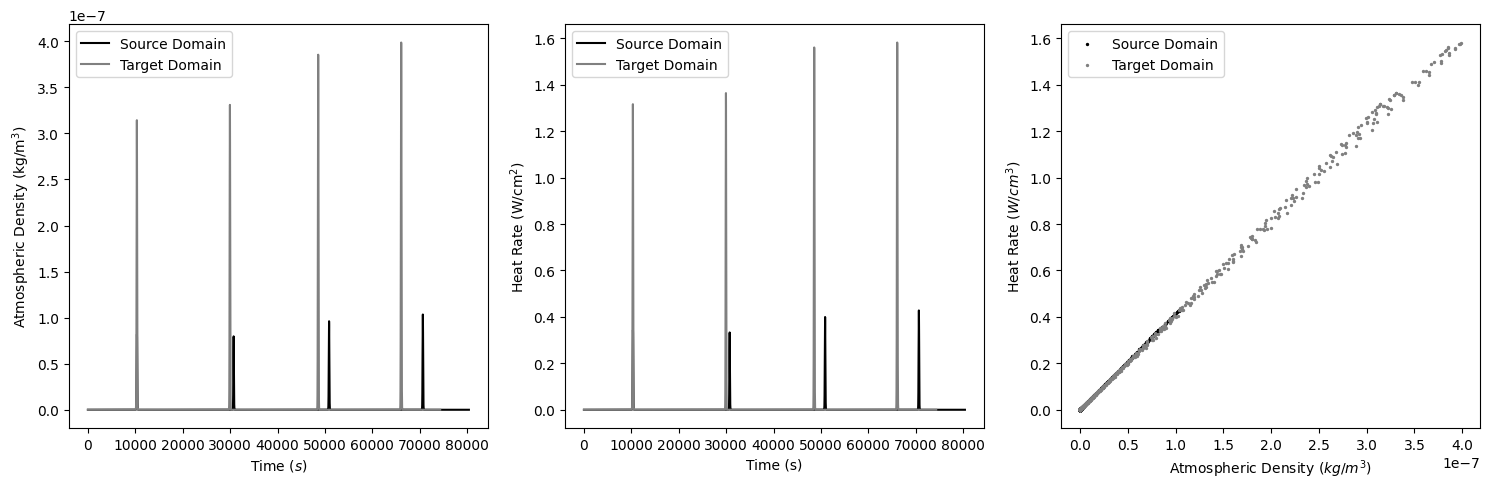

In [33]:
mission1_data_directory = r'data\4orbit_ra=12000_rp=100.0\Results_ctrl=0_ra=12000_rp=100.0_hl=0.150_90.0deg.csv'
mission2_data_directory = r'data\4orbit_ra=12000_rp=92.0\Results_ctrl=0_ra=12000_rp=92.0_hl=0.150_90.0deg.csv'
df1 = pd.read_csv(mission1_data_directory).drop_duplicates(subset=['time'], keep='first')
df2 = pd.read_csv(mission2_data_directory).drop_duplicates(subset=['time'], keep='first')

# Plotting
fig0, ax0 = plt.subplots(1,3,figsize=(15,5))
ax0[0].plot(df1['time'], df1['rho'], label="Source Domain", color='black')
ax0[0].plot(df2['time'], df2['rho'], label="Target Domain", color='gray')
ax0[0].set_xlabel('Time ($s$)')
ax0[0].set_ylabel('Atmospheric Density (kg/m$^3$)') 
ax0[0].legend()

ax0[1].plot(df1['time'], df1['heat_rate'], label="Source Domain", color='black')
ax0[1].plot(df2['time'], df2['heat_rate'], label="Target Domain", color='gray')
ax0[1].set_xlabel('Time (s)')
ax0[1].set_ylabel('Heat Rate (W/cm$^2$)')
ax0[1].legend() 

# Plotting state space
ax0[2].scatter(df1['rho'], df1['heat_rate'], s=2, label="Source Domain", color='black')
ax0[2].scatter(df2['rho'], df2['heat_rate'], s=2, label="Target Domain", color='gray')
ax0[2].set_xlabel('Atmospheric Density ($kg/m^3$)')
ax0[2].set_ylabel('Heat Rate ($W/{cm}^3$)') 
ax0[2].legend()
fig0.tight_layout()

plt.show()

Not especially surprising, right? Because the periapsis of the extrapolatory mission (`mission2`) is lower than that of the training mission (`mission1`), the density and heat rates encountered are much higher in the extrapolatory mission. Heat rate scales linearly with density, and the heat rate and density both spike in value when the spacecraft reenters the atmosphere and return to zero values when the spacecraft exits into the vacuum of space. 

A key aspect of the data to note is that both density and heat rate vary with time. I'll exploit that aspect to decompose the data with a technique called *singular spectrum analysis*.

# Finding Subspaces with Spectral Analysis
I'll use singular spectrum analysis (SSA) to find a subspace within a time-series. Why do I use SSA? Domain adaptation methods operate by finding common features within the data; a simple example of a common feature is to find a low-dimensional subspace of the data by principal component analysis (PCA), then project the data onto this subspace.  For our simple thermal model, an individual input (i.e., density value) is scalar, which has no features to exploit and no low-dimensional representation. SSA mitigates this by operating on *windows* of data wherein features are found within an individual window. The technique can be applied to our scalar input time-series to yield a viable subspace we can use for a subspace-based domain adaptation method.

SSA itself is fairly straightforward. The method has two steps: 1) embed a 1D vector into a trajectory matrix (i.e., a Hankel matrix) and 2) find the singular value decomposition (SVD) of the trajectory matrix. I'll first import some functions we'll need. 

- `find_trajectory_matrix` transforms a 1D vector into a Hankel matrix
- `H_to_TS` transforms a Hankel matrix into a 1D vector (i.e., reversal of `find_trajectory_matrix`)

Before proceeding any further, I'll extract the time, density, and heat rate columns from the dataframe and convert everything to `np.array`. I'll also mean center and scale to unit variance, and then interpolate the inputs in the source and target domains with respect to time. These interpolated inputs are useful for visualizing the data and will be important later.

In [34]:
from psa import find_trajectory_matrix, H_to_TS, interpolate_inputs

t1 = np.array(df1['time'])
rho1 = np.array(df1['rho']).reshape(-1,1)
Q1 = np.array(df1['heat_rate']).reshape(-1,1)

t2 = np.array(df2['time'])
rho2 = np.array(df2['rho']).reshape(-1,1)
Q2 = np.array(df2['heat_rate']).reshape(-1,1)

# Mean center and scale inputs to unit variance
scaler = StandardScaler(with_std=True)
rho1 = scaler.fit_transform(rho1)
rho2 = scaler.fit_transform(rho2)

# Interpolate inputs
rho1_interp, rho2_interp = interpolate_inputs(rho1,rho2,t1,t2)

Next, I'll find the trajectory matrices of the interpolated densities using a window length of 50. I plot the matrices using `matshow` but they look squashed because the matrix is of dimension $\mathbb{R}^{50 \times 3872}$. For a better visualization, I reshape the matrices to $\mathbb{R}^{440 \times 440}$ and plot these as well. Note that these reshaped square matrices are purely for visualization. We'll perform SSA exclusively on the original trajectory matrices.

Plotting trajectory matrices. Their dimensions are (50, 3872).


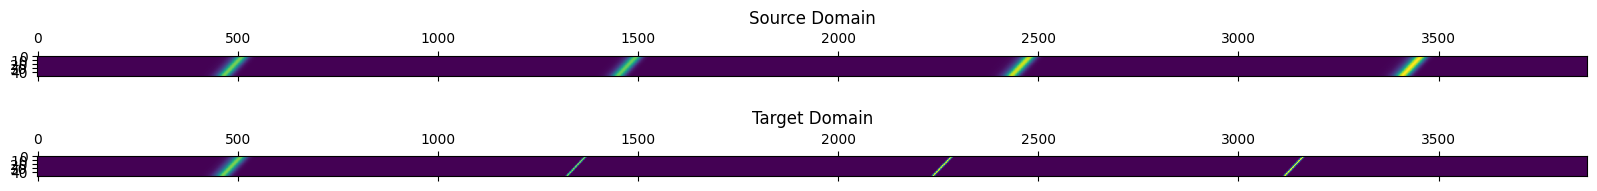

Plotting reshaped trajectory matrices for purely visualization purposes. Their dimensions are: (440, 440).


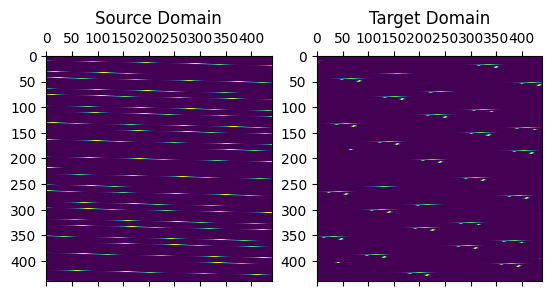

In [35]:
# Non-interpolated trajectory matrices
H_rho1 = torch.tensor(find_trajectory_matrix(rho1,window_length=50),dtype=torch.float32).to(device)
H_rho2 = torch.tensor(find_trajectory_matrix(rho2,window_length=50),dtype=torch.float32).to(device)

# Interpolated trajectory matrices
H_rho1_interp = find_trajectory_matrix(rho1_interp,window_length=50)
H_rho2_interp = find_trajectory_matrix(rho2_interp,window_length=50)

# Plotting trajectory matrices
print(f'Plotting trajectory matrices. Their dimensions are {H_rho1_interp.shape}.')
fig0, ax0 = plt.subplots(2,1,figsize=(20,10))
fig0.subplots_adjust(hspace=-0.85)
ax0[0].matshow(H_rho1_interp)
ax0[1].matshow(H_rho2_interp)
ax0[0].set_title('Source Domain')
ax0[1].set_title('Target Domain')
plt.show()

# Plotting reshaped trajectory matrices
H_rho1_square = H_rho1_interp.reshape(440,440)
H_rho2_square = H_rho2_interp.reshape(440,440)
print(f'Plotting reshaped trajectory matrices for purely visualization purposes. Their dimensions are: {H_rho1_square.shape}.')
fig1, ax1 = plt.subplots(1,2)
ax1[0].matshow(H_rho1_square)
ax1[1].matshow(H_rho2_square)
ax1[0].set_title('Source Domain')
ax1[1].set_title('Target Domain')
plt.show()

As I mentioned before, I'll take the SVD of the trajectory matrices.

In [36]:
H_rho1_interp = torch.tensor(H_rho1_interp,dtype=torch.float32).to(device)
H_rho2_interp = torch.tensor(H_rho2_interp,dtype=torch.float32).to(device)
Us,Ss,Vs = torch.linalg.svd(H_rho1_interp)
Ut,St,Vt = torch.linalg.svd(H_rho2_interp)

The SVD of each domain's trajectory matrix can be expressed as the sum of the eigentriple $\{ U_i, \sigma_i, V_i \}$
\begin{align*}
H_{\rho} = \sum_{i=1}^{d-1} \sigma_i U_i V_i^T = \sum_{i=1}^{d-1} H_{\rho}^{(i)}
\end{align*}
where $\sigma_i$ is the $i$-th singular value in the diagonal matrix $S$ found by SVD. Then, I'll plot the first 6 eigentriples of the source and target trajectory matrices to visualize their decomposition into trend, periodicity, and noise components.

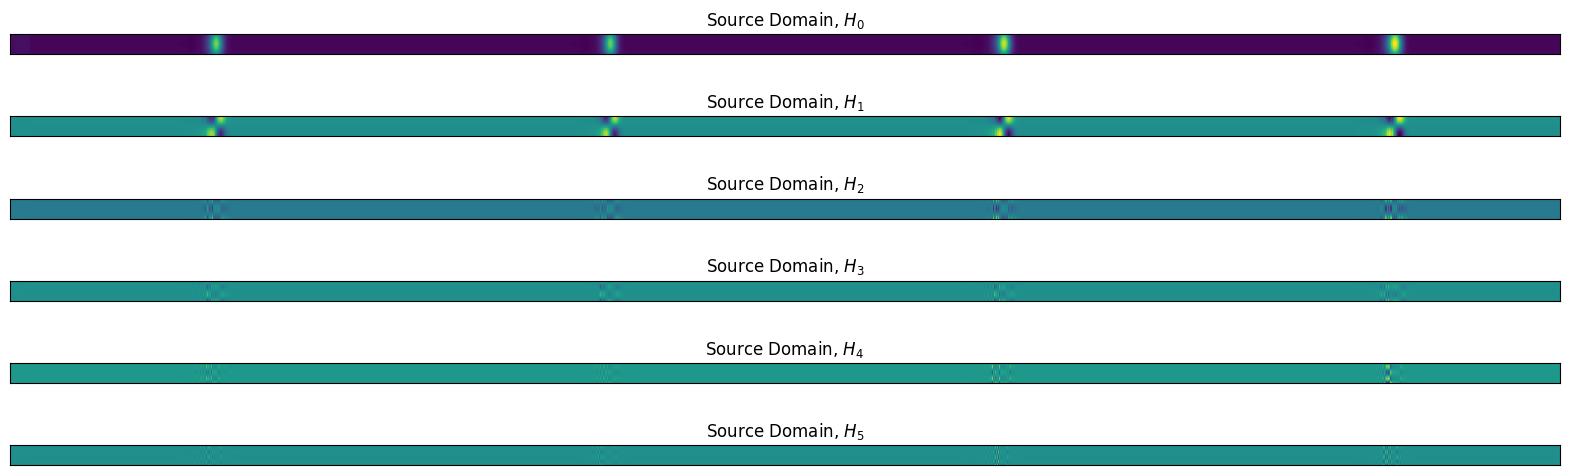

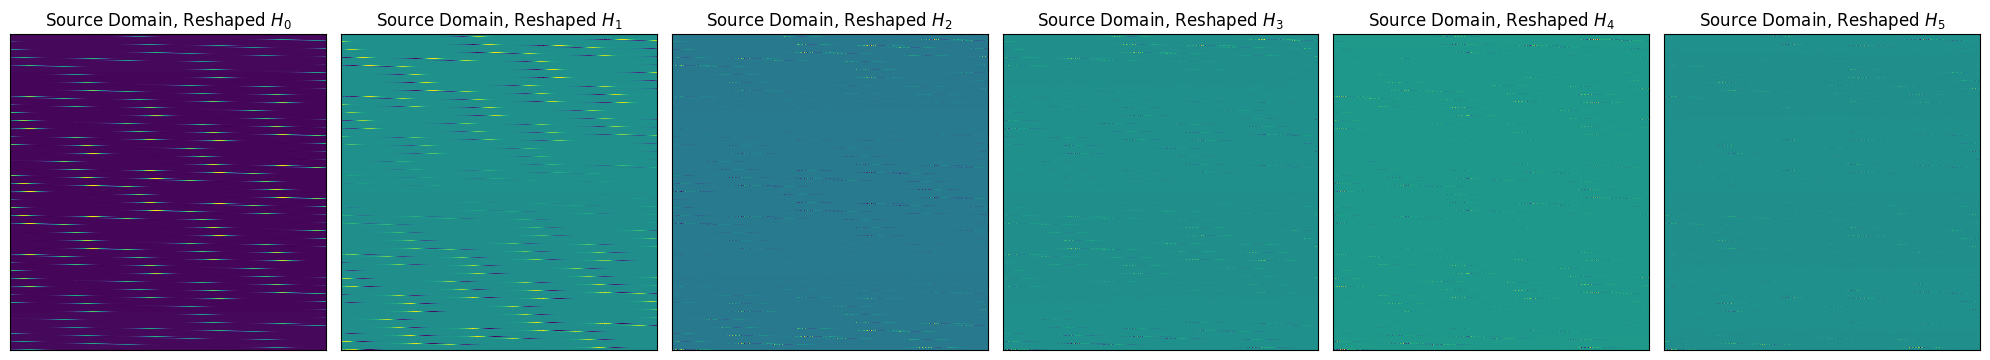

In [37]:
ds = np.linalg.matrix_rank(H_rho1_interp.cpu().detach().numpy())
H_rho1_elem = np.array([Ss[i].cpu().detach().numpy() * np.outer(Us[:,i].cpu().detach().numpy(), Vs[:,i].cpu().detach().numpy()) for i in range(0,ds)])

num_subplots = 6
fig2, ax2 = plt.subplots(num_subplots,1,figsize=(20,16))
fig2.subplots_adjust(hspace=-0.9)
for i in range(num_subplots):
    ax2[i].matshow(H_rho1_elem[i])
    ax2[i].set_title(f"Source Domain, $H_{str(i)}$")
    # Remove x-axis ticks and labels
    ax2[i].set_xticks([])
    ax2[i].set_xticklabels([])
    # Remove y-axis ticks and labels
    ax2[i].set_yticks([])
    ax2[i].set_yticklabels([])

fig3, ax3 = plt.subplots(1,num_subplots,figsize=(20,16))
for i in range(num_subplots):
    ax3[i].matshow(H_rho1_elem[i].reshape(440,440))
    ax3[i].set_title(f"Source Domain, Reshaped $H_{str(i)}$")
    # Remove x-axis ticks and labels
    ax3[i].set_xticks([])
    ax3[i].set_xticklabels([])
    # Remove y-axis ticks and labels
    ax3[i].set_yticks([])
    ax3[i].set_yticklabels([])
fig3.tight_layout()

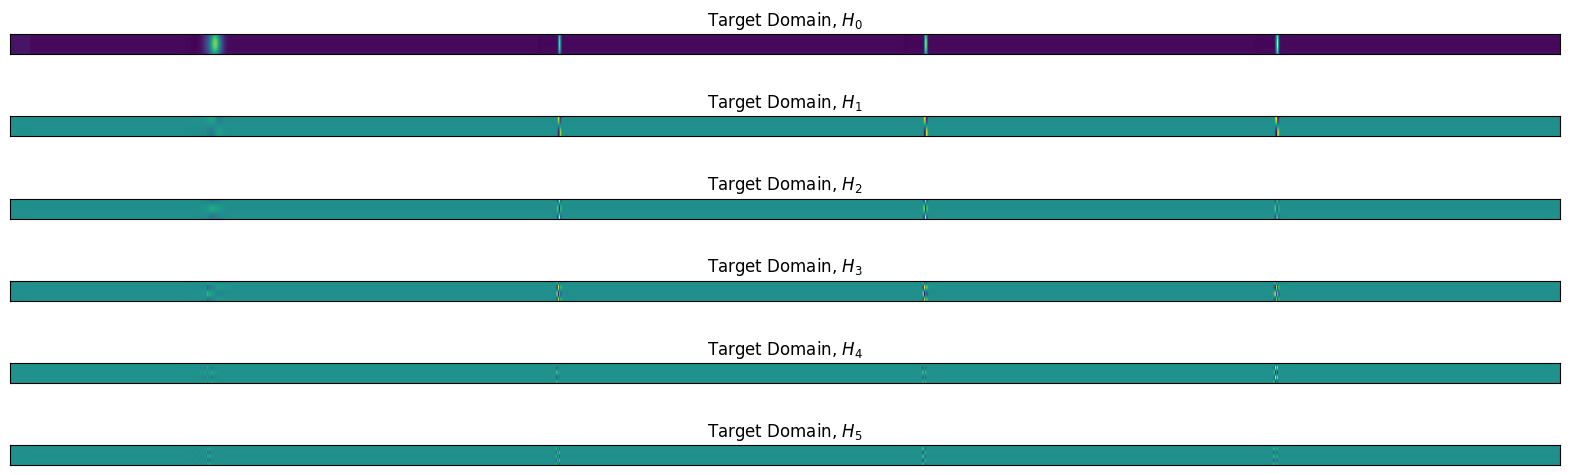

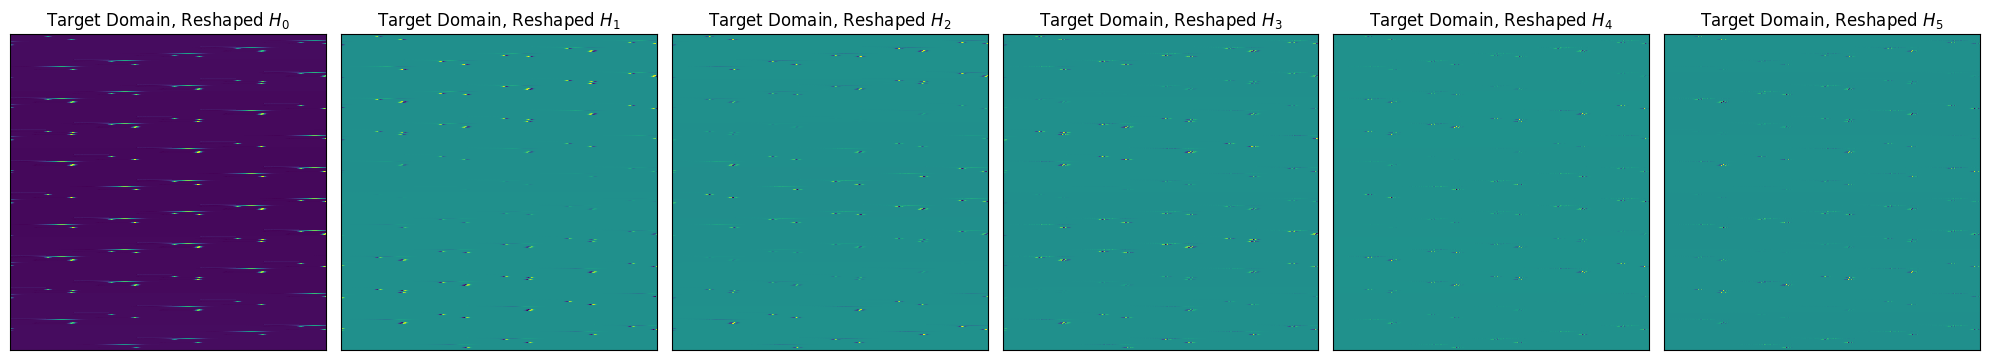

In [38]:
dt = np.linalg.matrix_rank(H_rho2_interp.cpu().detach().numpy())
H_rho2_elem = np.array([St[i].cpu().detach().numpy() * np.outer(Ut[:,i].cpu().detach().numpy(), Vt[:,i].cpu().detach().numpy()) for i in range(0,dt)])

num_subplots = 6
fig4, ax4 = plt.subplots(num_subplots,1,figsize=(20,16))
fig4.subplots_adjust(hspace=-0.9)
for i in range(num_subplots):
    ax4[i].matshow(H_rho2_elem[i])
    ax4[i].set_title(f"Target Domain, $H_{str(i)}$")
    # Remove x-axis ticks and labels
    ax4[i].set_xticks([])
    ax4[i].set_xticklabels([])
    # Remove y-axis ticks and labels
    ax4[i].set_yticks([])
    ax4[i].set_yticklabels([])

fig5, ax5 = plt.subplots(1,num_subplots,figsize=(20,16))
for i in range(num_subplots):
    ax5[i].matshow(H_rho2_elem[i].reshape(440,440))
    ax5[i].set_title(f"Target Domain, Reshaped $H_{str(i)}$")
    # Remove x-axis ticks and labels
    ax5[i].set_xticks([])
    ax5[i].set_xticklabels([])
    # Remove y-axis ticks and labels
    ax5[i].set_yticks([])
    ax5[i].set_yticklabels([])
fig5.tight_layout()

The primary purpose of showing this decomposition is to identify how many singular vectors to keep as a subspace while retaining a sufficient amount of information within the data. From the plots, it's clear that the first four singular vectors contribute the most to the underlying structure of the trajectory matrices. We can confirm this by plotting the relative contribution of each vector in a scree plot.

[6.43193741e+01 2.70320053e+01 6.96430349e+00 1.42105603e+00
 2.27925852e-01 3.05741727e-02 3.33521096e-03 3.98307893e-04
 1.10844499e-04 5.82974608e-05 4.47233433e-05 4.46936247e-05
 4.36643131e-05 4.35335496e-05 4.13065136e-05 3.84939558e-05
 3.34830038e-05 3.04376608e-05 3.01177097e-05 2.77082963e-05
 2.68849872e-05 2.50394769e-05 2.50297198e-05 2.44557814e-05
 2.31469676e-05 2.26932407e-05 2.07173362e-05 2.00888153e-05
 1.92868320e-05 1.92771731e-05 1.88317135e-05 1.84871315e-05
 1.83408156e-05 1.77204820e-05 1.72805176e-05 1.70140102e-05
 1.54986883e-05 1.51832382e-05 1.48469553e-05 1.46661132e-05
 1.33230205e-05 1.29566724e-05 1.08894174e-05 1.07792630e-05
 9.48235629e-06 6.76523177e-06 6.60028991e-06 6.28969610e-06
 5.46986803e-06 5.08427229e-06]


Text(0, 0.5, 'Explained Variance')

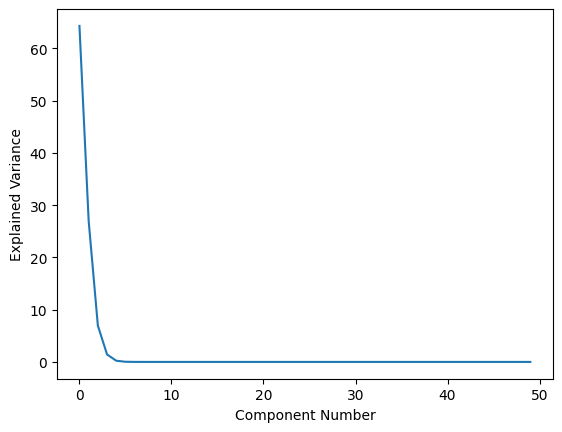

In [39]:
# Calculate contribution of each principal component
sigma_sumsq = (Ss**2).sum()
print(Ss.cpu().detach().numpy()**2 / sigma_sumsq.cpu().detach().numpy() * 100) 
plt.plot(Ss.cpu().detach().numpy()**2 / sigma_sumsq.cpu().detach().numpy() * 100)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')

I'll proceed to truncate the left singular vector matrix for the source domain, keeping only the top 4 left singular vectors. These top 4 left singular vectors are the subspace $H_{\rho,\mathrm{sub}}$ for the training mission. Note that the source domain subspace is found by PCA.

In [40]:
k = 5
H_rho1_sub = Us[:,0:k]
H_rho1_sub = torch.tensor(H_rho1_sub,dtype=torch.float32).to(device)

C:\Users\Paul\AppData\Local\Temp\ipykernel_2888\3634805290.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_rho1_sub = torch.tensor(H_rho1_sub,dtype=torch.float32).to(device)


Because I'm interested in online adaptation, I'm going to show an alternative method to find `H_rho2_sub` by *subspace tracking* using Oja's algorithm. I can treat each window of the trajectory matrix as streaming and received sequentially from sensor data. Given an initial random orthonormal guess of the target domain subspace, each column of the trajectory matrix can be used to update this subspace guess, with the new updates performed on the previous subspace estimate, such that

\begin{align*}
H_{\rho_i,\mathrm{sub}} = H_{\rho_{i-1},\mathrm{sub}} + \eta H_{\rho}^{(i)} \left( H_{\rho}^{(i)} \right)^T H_{\rho_{i-1},\mathrm{sub}} \quad \forall i \in [0, (n-L+1)]
\end{align*}

where $H_{\rho}^{(i)}$ is the $i$-th column of the matrix $H_{\rho}$, and $H_{\rho_i,\mathrm{sub}}$ and $H_{\rho_{i-1},\mathrm{sub}}$ are the subspace estimates at the $i$-th and $i-1$-th iteration, respectively. Here's the code to do this.

In [41]:
Y = H_rho2_interp.T.cpu().detach().numpy()
n_samples, n_features = Y.shape
eta = 0.5
errors = []

Uhat = linalg.orth(np.random.randn(H_rho1_sub.shape[0],H_rho1_sub.shape[1]))
Utrue = Ut[:,0:k].cpu().detach().numpy()

for i in range(n_samples):
    y = Y[i, :].reshape(-1, 1)  # Column vector
    
    # Oja's update
    Uhat += eta * y @ (Uhat.T @ y).T
    
    # Re-orthogonalize U
    Uhat = orth(Uhat)

    error = linalg.norm(Utrue - Uhat @ (Uhat.T @ Utrue),ord='fro')**2
    errors.append(error)

H_rho2_sub = Uhat
H_rho2_sub = torch.tensor(H_rho2_sub,dtype=torch.float32).to(device)

# Aligning the Subspaces

torch.Size([50, 3872]) torch.Size([50, 3902])
torch.Size([50, 5]) torch.Size([50, 5])
torch.Size([5, 3872]) torch.Size([5, 3872])
(3872, 5) (3872, 5)


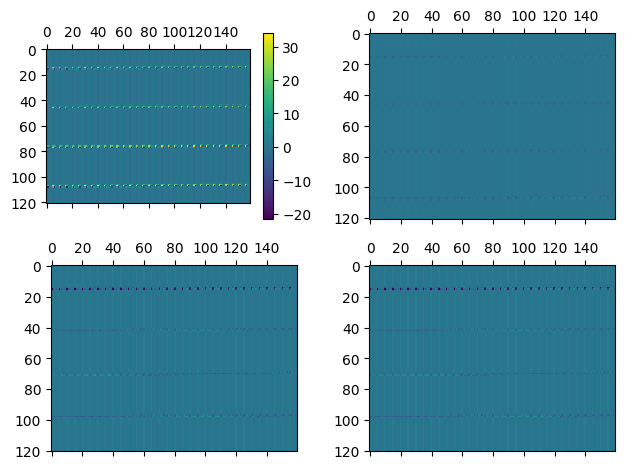

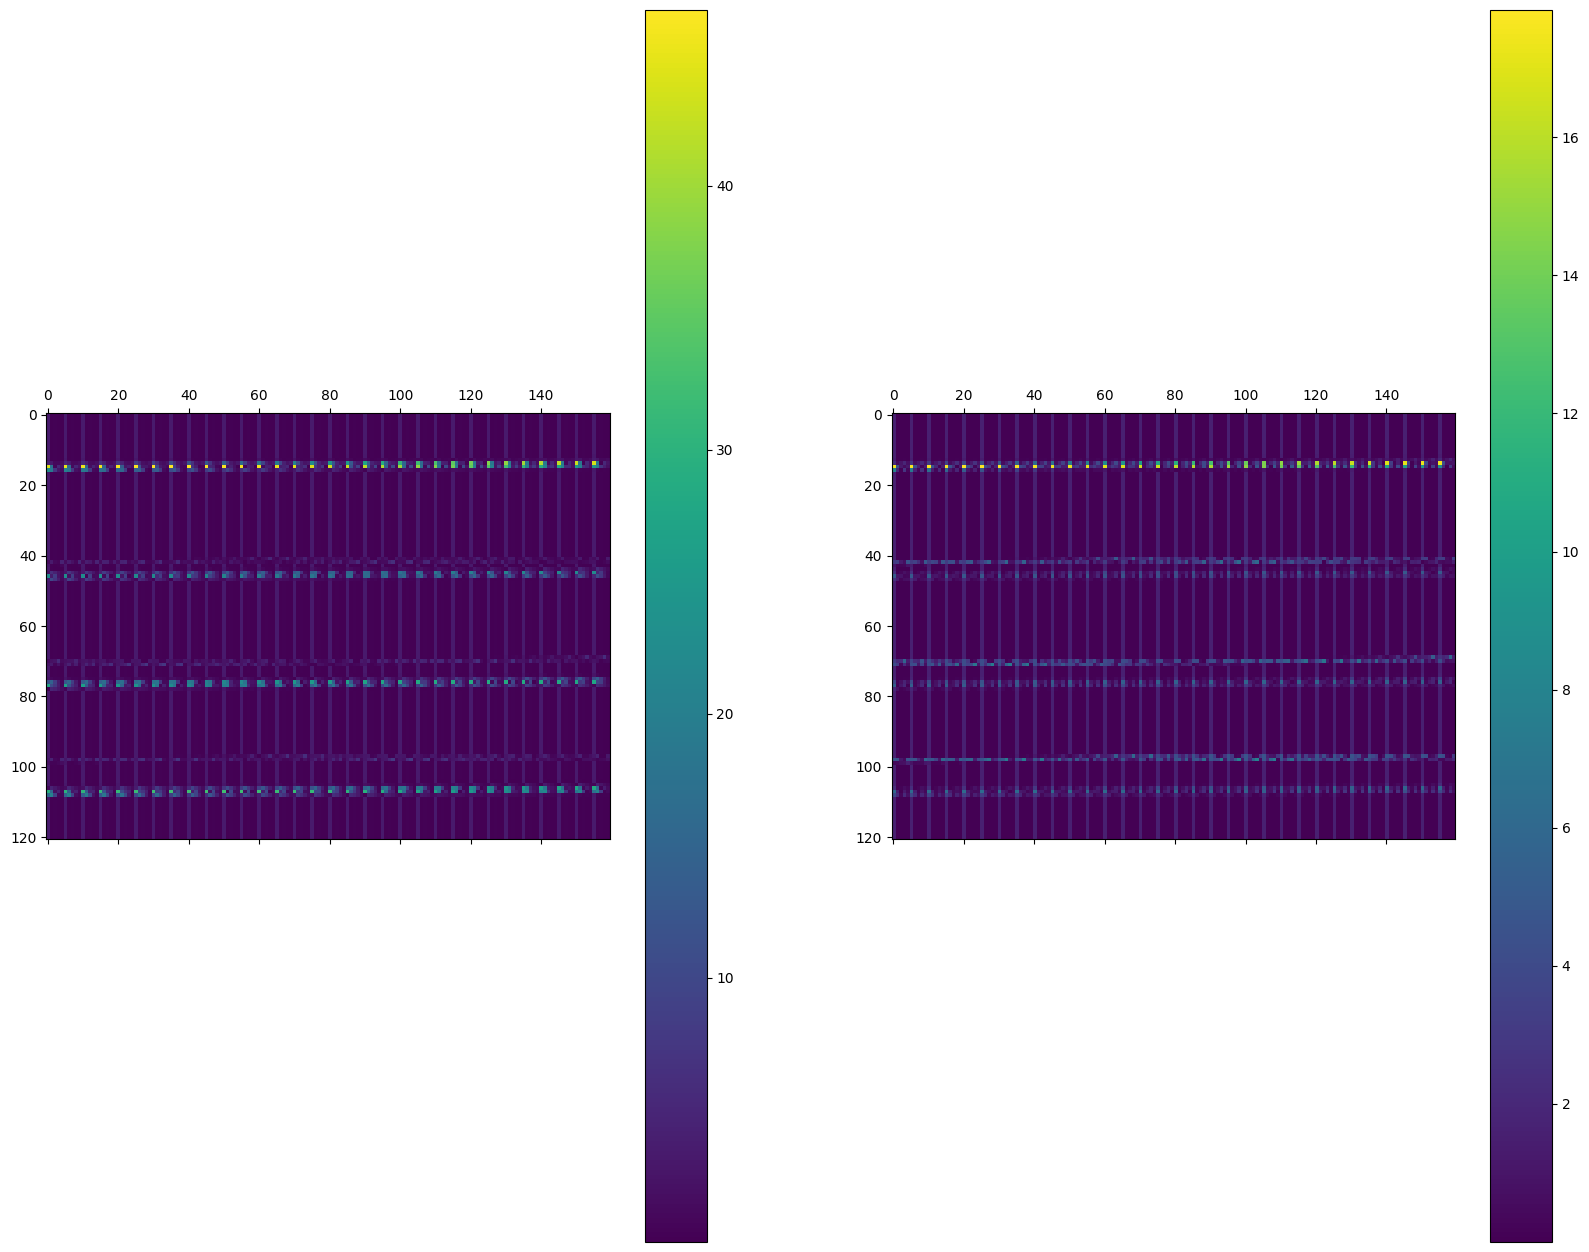

In [45]:
H_rho1_proj = H_rho1_sub.T @ H_rho1_interp
H_rho2_proj = H_rho2_sub.T @ H_rho2_interp

U,S,V = torch.linalg.svd(H_rho1_proj @ H_rho2_proj.T)
Q = V.T @ U.T
s = torch.trace(torch.diag(S))/torch.trace(H_rho1_proj @ H_rho1_proj.T)

Xa = s * Q @ (H_rho1_sub.T @ H_rho1_interp)

Za = H_rho2_sub.T @ H_rho2_interp
Xa = Xa.T
Za = Za.T
# Hankelise outputs
Ys_H = find_trajectory_matrix(Q1,window_length=50)
Yt_H = find_trajectory_matrix(Q2,window_length=50)

Xa = Xa.cpu().detach().numpy()
Za = Za.cpu().detach().numpy()
Ys_H = Ys_H.T
Yt_h = Yt_H.T

print(H_rho1.shape, H_rho2.shape)
print(H_rho1_sub.shape,H_rho2_sub.shape)
print(H_rho1_proj.shape,H_rho2_proj.shape)
print(Xa.shape,Za.shape)

fig6, ax6 = plt.subplots(2,2)
colnum = 160
vmin = np.min(H_rho1_proj.ravel().cpu().detach().numpy())
vmax = np.max(H_rho1_proj.ravel().cpu().detach().numpy())
cmap = 'viridis'


H_rho1_proj_np = H_rho1_proj.cpu().detach().numpy()
H_rho2_proj_np = H_rho2_proj.cpu().detach().numpy()
im = ax6[0,0].matshow(H_rho1_proj_np.T.reshape(-1,colnum), vmin=vmin, vmax=vmax, cmap=cmap)
ax6[1,0].matshow(H_rho2_proj_np.T.reshape(-1,colnum), vmin=vmin, vmax=vmax, cmap=cmap)
ax6[0,1].matshow(Xa.reshape(-1,colnum), vmin=vmin, vmax=vmax, cmap=cmap)
ax6[1,1].matshow(Za.reshape(-1,colnum), vmin=vmin, vmax=vmax, cmap=cmap)
fig6.colorbar(im)
fig6.tight_layout()

vmin = np.min(H_rho1_proj.ravel().cpu().detach().numpy())
vmax = np.max(H_rho1_proj.ravel().cpu().detach().numpy())
cmap = 'viridis'

fig7, ax7 = plt.subplots(1,2,figsize=(20,16))
im1 = ax7[0].matshow(np.abs(H_rho1_proj_np.T.reshape(-1,colnum)-H_rho2_proj_np.T.reshape(-1,colnum)))
im2 = ax7[1].matshow(np.abs(Xa.reshape(-1,colnum)-Za.reshape(-1,colnum)))
fig7.colorbar(im1)
fig7.colorbar(im2)

# 